In [1]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import seaborn as sns


# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)


# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)

    return M

/tmp/ipykernel_279050/2323444922.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'brainstat'

## Create a brain mask derived from the thickness

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/vtk_interface/wrappers/data_object.py:166: UserWarning: Input array is boolean. Casting to uint8.
  warnings.warn('Input array is boolean. Casting to uint8.')


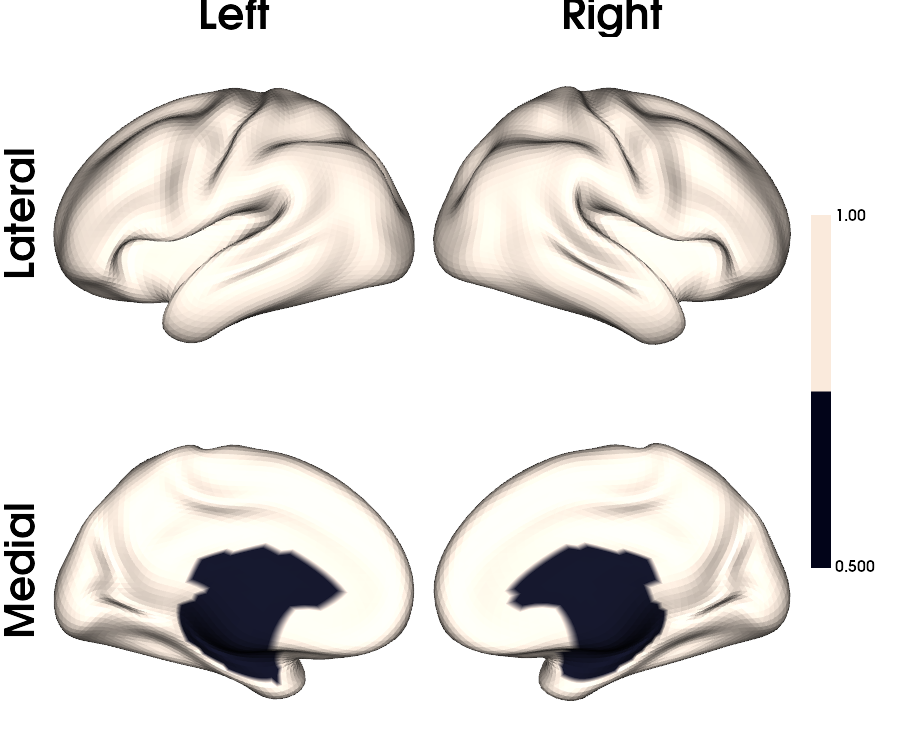

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

## fsLR-5k qMRI maps

In [3]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [13]:
def load_qmri_group(qmri=''):
    '''
    This function loads and plots the qMRI intensity maps on fsLR5k midthickness
    '''
    # List the files
    #files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm1.0vox_{qmri}.func.gii"))
    #files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm1.0vox_{qmri}.func.gii"))
    files_swm = sorted(glob.glob(f"sub-*/ses-*/mpc-swm/acq-odi/sub-PNC019_ses-02_surf-fsLR-5k_desc-intensity_profiles.shape.gii"))
    
    # Load all the thickness data
    Nqmri=np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

    surf_map=np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i,:] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
    N = surf_map.shape[0]
    print(f"Numer of {qmri} maps: {N}")               
    return(map_mean,surf_map)

def plot_qmri_int(qmri='', midwall_mask=False, cmap='rocket', horiz=False, rq=(0.01, 0.99)):
    map_mean,_ = load_qmri_group(qmri)
    
    #map_mean_normalized = (map_mean - np.min(map_mean)) / (np.max(map_mean) - np.min(map_mean))
    
    # Plot the group T1map intensitites
    crange=(np.quantile(map_mean[mask_5k], rq[0]), np.quantile(map_mean[mask_5k], rq[1]))

    # Replace values in f with NaN where mask_5k is False
    if midwall_mask == True: map_mean[mask_5k == False] = np.nan
    
    if horiz == True:
        fig = plot_hemispheres(inf32_rh, inf32_lh, array_name=map_mean, size=(900, 250), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap=cmap, color_range=crange, transparent_bg=False, screenshot = False)

    else:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, cmap=cmap, nan_color=(0, 0, 0, 1),
                  zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', layout_style='grid', color_range=crange,
                  label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)
        
    return(fig)

Numer of T1map maps: 20


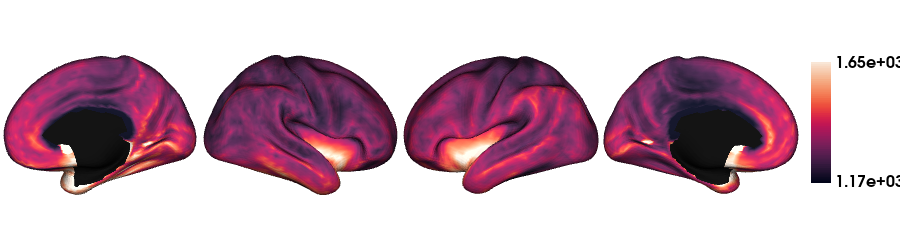

In [14]:
plot_qmri_int(qmri='T1map', midwall_mask=True, cmap='rocket', horiz=True)

## Microstructural profile by SWM depth

In [15]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")

    return map_means

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9


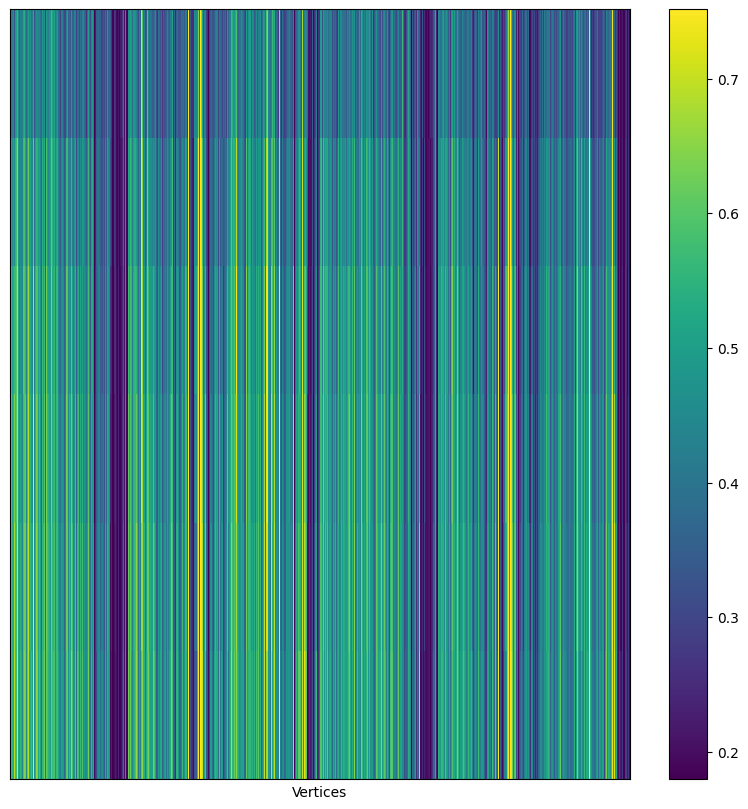

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#depth_list = ['0.5mm', '1.0mm', '1.5mm', '2.0mm', '2.5mm', '3.0mm']

result = load_qmri_group(qmri='FA')
result_matrix = np.array(result)

# Calculate the quantiles for the color range
map_crange=(np.quantile(result_matrix[:, mask_5k], 0.01), np.quantile(result_matrix[:, mask_5k], 0.99))

# Adjust the figure size as per your requirement
plt.figure(figsize=(10, 10))  # Adjust the values (width, height) as needed

# Plot the pcolormesh
pcm = plt.pcolormesh(np.flipud(result_matrix), cmap='viridis', shading='auto', vmin=map_crange[0], vmax=map_crange[1])
#plt.yticks(np.arange(len(depth_list)) + 0.5, depth_list)

# Set colorbar scale to display only the minimum and maximum values
plt.colorbar(label='')

# Set labels
plt.xlabel('Vertices')
plt.yticks([])  # Remove y-axis labels

plt.show()

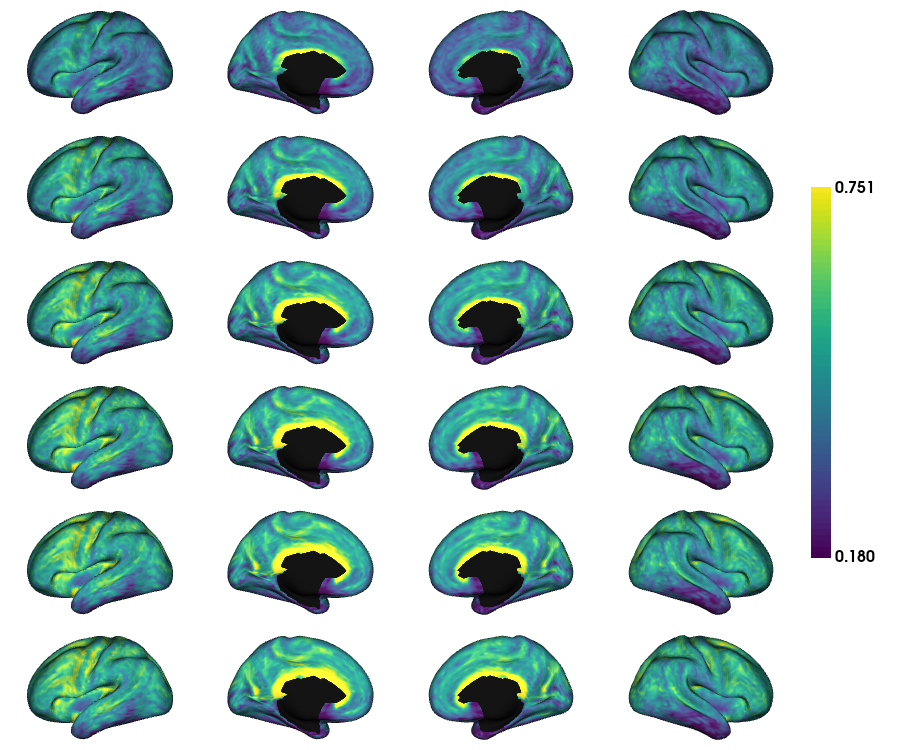

In [17]:
result_array = np.array(result)

# Calculate the quantiles for the color range
map_crange=(np.quantile(result_array[:, mask_5k], 0.01), np.quantile(result_array[:, mask_5k], 0.99))

result_array[:, mask_5k == False] = np.nan

# Plot with the new color range
plot_hemispheres(inf32_lh, inf32_rh, array_name=result_array, size=(900, 750), color_bar='right', zoom=1.5, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='viridis', transparent_bg=False, screenshot=False, color_range=map_crange)

## Correlation matrix between group mean intensity (Average)

In [18]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return average_map_means

In [19]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTSAT', 'T2star', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    average_map_means = process_qmri(qmri)
    map_means[qmri] = average_map_means
    
map_means_concat = np.concatenate(
    [average_map_means[:, np.newaxis] for average_map_means in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Number of T1map maps for depth 1.0: 20
Number of T1map maps for depth 2.0: 20
Number of T1map maps for depth 3.0: 20
Number of T1map maps for depth 4.0: 20
Number of T1map maps for depth 5.0: 20
Number of T1map maps for depth 6.0: 20
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9
Number of T2star maps for depth 1.0: 8
Number of T2star maps for depth 2.0: 8
Number of T2star maps for depth 3.0: 8
Number of T2star maps for depth 4.0: 8
Number of T2star maps for depth 5.0: 8
Number of T2star maps for depth 6.0: 8
Number of ADC maps for depth 1.0: 9
Number of ADC maps for depth 2.0: 9
Number of ADC maps for depth 3.0: 9
Number of ADC maps for depth 4.0: 9
Number of ADC maps for depth 5.0: 9
Number of ADC maps for depth 6.0: 9
Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps 

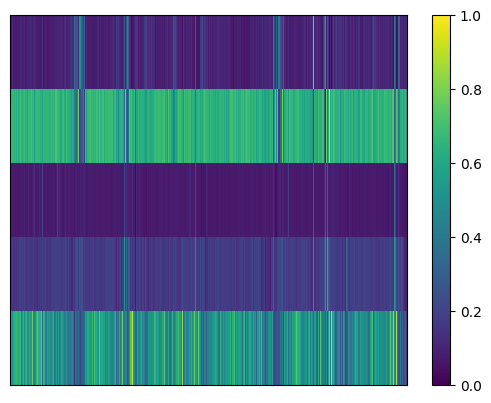

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

qmri_list = ['FA', 'ADC', 'T2star', 'MTSAT', 'T1map']

plt.pcolormesh(np.flipud(normalized_map_means.T), cmap='viridis', shading='auto')
plt.yticks(np.arange(len(qmri_list)) + 0.5, qmri_list)
plt.colorbar(label='')

#plt.xlabel('Cortical Vertex')
#plt.ylabel('qMRI')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

plt.show()

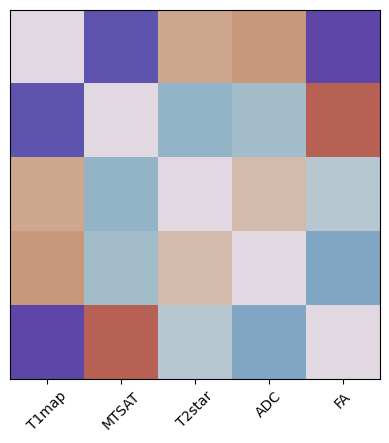

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['T1map', 'MTSAT', 'T2star', 'ADC', 'FA']

#correlation_matrix = np.corrcoef(map_means_concat.T) # Calculate Pearson correlation
correlation_matrix, _ = spearmanr(map_means_concat) # Calculate Spearman correlation 

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, 0)

plt.imshow(correlation_matrix, cmap='twilight_shifted', vmin=-1, vmax=1, aspect='equal')
#plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list, rotation=45)
plt.yticks(np.arange(len(qmri_list)), qmri_list, rotation=45)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelright'] = True
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

In [148]:
correlation_matrix

array([[ 0.        , -0.61354172,  0.23478105,  0.28412329, -0.65865287],
       [-0.61354172,  0.        , -0.2537603 , -0.21013933,  0.46627448],
       [ 0.23478105, -0.2537603 ,  0.        ,  0.16721088, -0.15741779],
       [ 0.28412329, -0.21013933,  0.16721088,  0.        , -0.31044856],
       [-0.65865287,  0.46627448, -0.15741779, -0.31044856,  0.        ]])

## Differences by SWM depth

In [22]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return map_means

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
2023-11-29 17:17:01,784 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


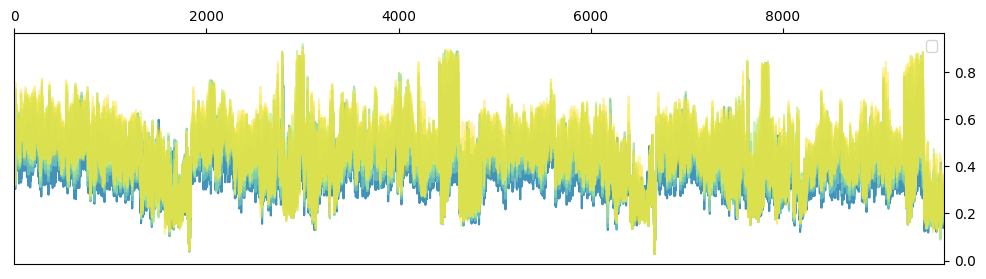

In [23]:
import matplotlib.pyplot as plt

def plot_qmri_group(map_means):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # Adjust the figure size for a wider graph
    plt.figure(figsize=(12, 3))

    # Set the background color to gray
    #plt.gca().set_facecolor('lightgray')

     # Define custom RGB colors for each depth
    colors = [(66, 146, 185, 255), (112, 196, 188, 200), (143, 215, 159, 180), (178, 231, 130, 150), (255, 245, 78, 120), (254, 211, 3, 80)]
    
    for i, depth in enumerate(depths):
    #reversed(list(enumerate(depths))):
        color = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255, colors[i][3]/255)
        plt.plot(map_means[i], color=color)
        #label=f'SWM {depth} mm'

    # Set x-axis range from 0 to the maximum vertex index
    max_vertex_index = len(map_means[0]) - 1
    plt.xlim(0, max_vertex_index)
    
    #plt.title('Comparison of Intensity for Different Depths')
    plt.legend()
    plt.show()

# Assuming you have already loaded the map_means data
map_means_data = load_qmri_group(qmri='FA')
plot_qmri_group(map_means_data)

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps for depth 3.0: 9
Number of FA maps for depth 4.0: 9
Number of FA maps for depth 5.0: 9
Number of FA maps for depth 6.0: 9
2023-11-28 00:01:21,882 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


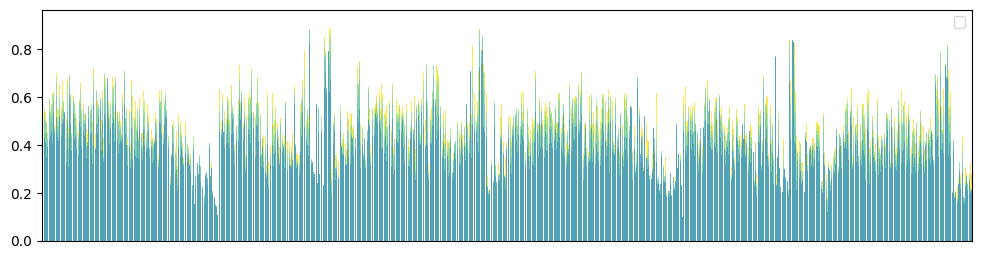

In [341]:
import matplotlib.pyplot as plt

def plot_qmri_group(map_means):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

    # Adjust the figure size for a wider graph
    plt.figure(figsize=(12, 3))

    # Set the background color to gray
    #plt.gca().set_facecolor('lightgray')

     # Define custom RGB colors for each depth
    #colors = [(66, 146, 185, 255), (112, 196, 188, 200), (143, 215, 159, 150), (178, 231, 130, 100), (255, 245, 78, 80), (254, 211, 3, 20)]
    colors = [(66, 146, 185, 20), (112, 196, 188, 80), (143, 215, 159, 100), (178, 231, 130, 150), (255, 245, 78, 200), (254, 211, 3, 255)]

    for i, depth in reversed(list(enumerate(depths))):
    #enumerate(depths):
    #reversed(list(enumerate(depths))):
        color = (colors[i][0]/255, colors[i][1]/255, colors[i][2]/255, colors[i][3]/255)
        plt.bar(range(len(map_means[i])), map_means[i], color=color, alpha=0.7)
        #label=f'SWM {depth} mm'

    # Set x-axis range from 0 to the maximum vertex index
    max_vertex_index = len(map_means[0]) - 1
    plt.xlim(0, max_vertex_index)
    
    #plt.title('Comparison of Intensity for Different Depths')
    plt.legend()
    plt.show()

# Assuming you have already loaded the map_means data
map_means_data = load_qmri_group(qmri='FA')
plot_qmri_group(map_means_data)

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

## Correlation matrix between group mean intensity (by depth)

In [52]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    map_mean = process_qmri(qmri)
    map_means[qmri] = map_mean
    
map_means_concat = np.concatenate(
    [map_mean[:, np.newaxis] for map_mean in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Numer of T1map maps: 10
Numer of MTR maps: 9
Numer of MTSAT maps: 9
Numer of ADC maps: 1
Numer of FA maps: 1


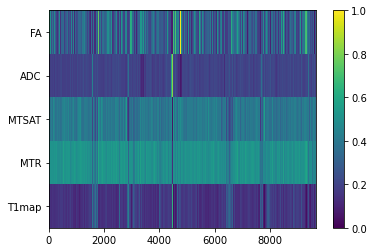

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

plt.pcolormesh(normalized_map_means.T, cmap='viridis', shading='auto')
plt.yticks(np.arange(len(qmri_list)) + 0.5, qmri_list)
plt.colorbar(label='')

#plt.xlabel('Cortical Vertex')
#plt.ylabel('qMRI')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

plt.show()

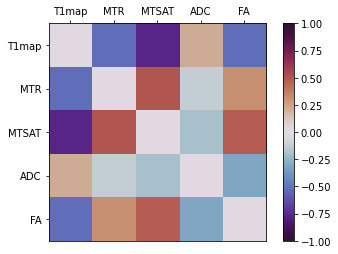

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
#import matplotlib as mpl

qmri_list = ['T1map', 'MTR', 'MTSAT', 'ADC', 'FA']

#correlation_matrix = np.corrcoef(map_means_concat.T) # Calculate Pearson correlation
correlation_matrix, _ = spearmanr(map_means_concat) # Calculate Spearman correlation 

# Set the diagonal values to 0
np.fill_diagonal(correlation_matrix, 0)

plt.imshow(correlation_matrix, cmap='twilight_shifted', vmin=-1, vmax=1, aspect='equal')
plt.colorbar()
plt.xticks(np.arange(len(qmri_list)), qmri_list)
plt.yticks(np.arange(len(qmri_list)), qmri_list)

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labeltop'] = True
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

plt.show()

## Group Similarity

In [61]:
def load_qmri_group(qmri=''):
    depth_values = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    
    # Initialize the total_surf_map to accumulate the matrices
    total_surf_map = None

    for depth in depth_values:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)

        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Accumulate the matrices
        if total_surf_map is None:
            total_surf_map = surf_map
        else:
            total_surf_map += surf_map

    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(total_surf_map, axis=0)
    N = total_surf_map.shape[0]
    print(f"Number of {qmri} maps: {N}")               
    return total_surf_map, map_mean

In [62]:
# T1map (10 subject - only ses-03)
T1map_data, T1map_mean_matrix = load_qmri_group(qmri='T1map')
# delete sub-PNC015 (9 subject)
T1map_data = np.delete(T1map_data, 6, axis=0)

Number of T1map maps: 10


In [59]:
# FA (9 subject- ses-*)
FA_data, FA_mean_matrix = load_qmri_group(qmri='FA')

# MTSAT (9 subject - ses-*)
MTSAT_data, MTSAT_mean_matrix = load_qmri_group(qmri='MTSAT')

Number of FA maps: 9
Number of MTSAT maps: 9


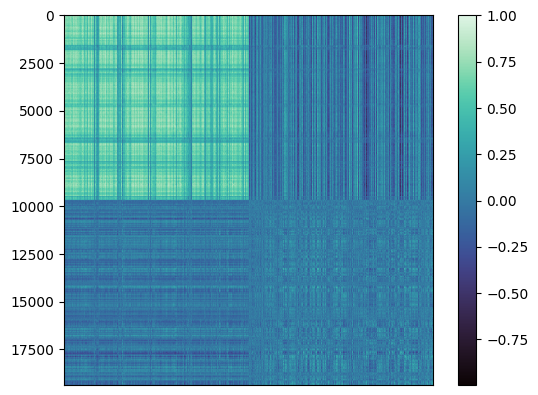

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(MTSAT_data.T, FA_data.T)

plt.imshow(correlation_matrix, cmap='mako', aspect='equal')
plt.colorbar(label='')

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False

plt.show()

In [63]:
print(T1map_data.shape)
print(FA_data.shape)

(9, 9684)
(9, 9684)


### T1map - FA Correlation Matrix

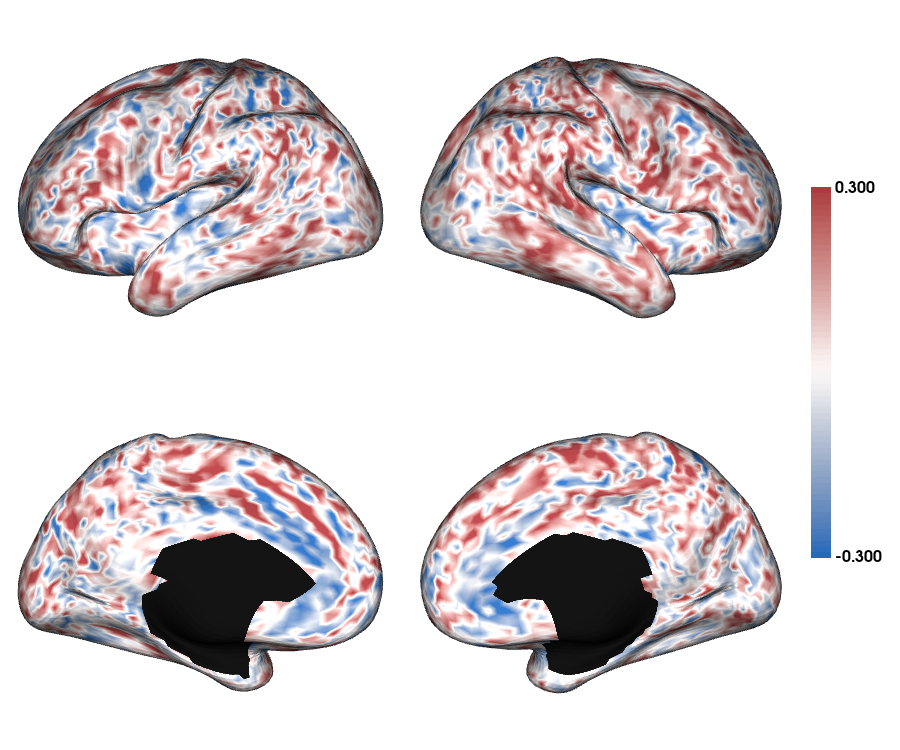

In [64]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_data.T, FA_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:T1map_data.shape[1], T1map_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.3, 0.3)

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=new_crange)

### T1map - MTSAT Correlation Matrix

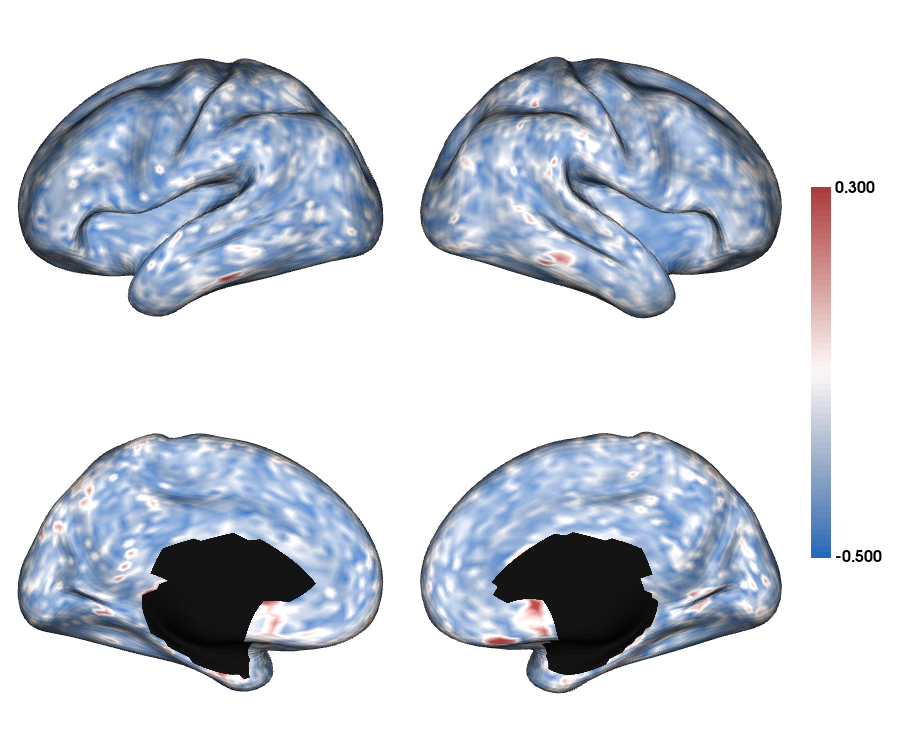

In [66]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(T1map_data.T, MTSAT_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:T1map_data.shape[1], T1map_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.5, 0.3)

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=new_crange)

### MTSAT - FA Correlation Matrix

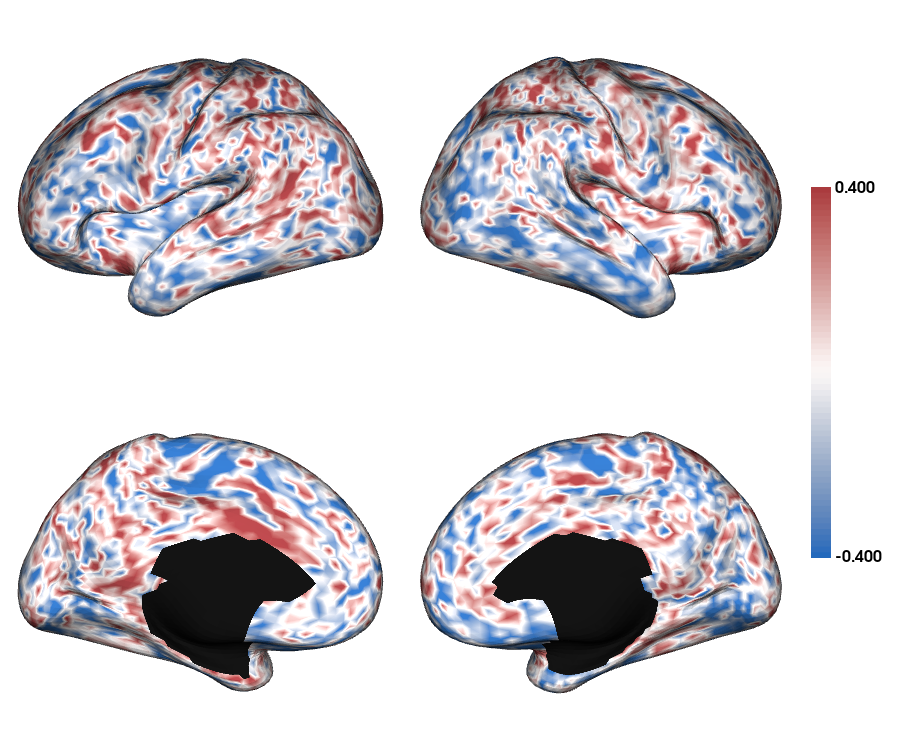

In [67]:
# Calculate the correlation coefficients
correlation_matrix = np.corrcoef(MTSAT_data.T, FA_data.T)

# Extract the correlation values between the two matrices
vertex_wise_correlation = correlation_matrix[:MTSAT_data.shape[1], MTSAT_data.shape[1]:]

# Calculate the mean for each column
corr_means = np.mean(vertex_wise_correlation, axis=0)

# Set your desired color range (replace min_value and max_value)
new_crange = (-0.4, 0.4)

corr_means[mask_5k == False] = np.nan

plot_hemispheres(inf32_lh, inf32_rh, array_name=corr_means, size=(900, 750), color_bar='right', zoom=1.25, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='vlag', layout_style='grid', transparent_bg=False, screenshot=False, color_range=new_crange)

## Scatter Plot

In [31]:
def load_qmri_group(qmri=''):
    depths = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    map_means = []  # List to store map_mean values for each depth

    for depth in depths:
        # List the files
        files_lh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-L_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))
        files_rh = sorted(glob.glob(f"sub-*/ses-*/maps/*_hemi-R_surf-fsLR-5k_label-swm{depth}vox_{qmri}.func.gii"))

        # Load all the thickness data
        Nqmri = np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

        surf_map = np.empty([len(files_lh), Nqmri], dtype=float)
        for i, _ in enumerate(files_lh):
            surf_map[i, :] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

        # Mean matrix across the x-axis (vertices)
        map_mean = np.mean(surf_map, axis=0)
        map_means.append(map_mean)

        N = surf_map.shape[0]
        print(f"Number of {qmri} maps for depth {depth}: {N}")
        
        # Compute the mean across the columns
        average_map_means = np.mean(map_means, axis=0)

    return average_map_means

In [32]:
def process_qmri(qmri, cmap='rocket'):
    return load_qmri_group(qmri=qmri)

qmri_list = ['T1map', 'MTSAT', 'T2star', 'ADC', 'FA']

map_means = {}

for qmri in qmri_list:
    average_map_means = process_qmri(qmri)
    map_means[qmri] = average_map_means
    
map_means_concat = np.concatenate(
    [average_map_means[:, np.newaxis] for average_map_means in map_means.values()],
    axis=1)

# Normalize each column to be between 0 and 1
normalized_map_means = (map_means_concat - np.min(map_means_concat, axis=0)) / (np.max(map_means_concat, axis=0) - np.min(map_means_concat, axis=0))

Number of T1map maps for depth 1.0: 20
Number of T1map maps for depth 2.0: 20
Number of T1map maps for depth 3.0: 20
Number of T1map maps for depth 4.0: 20
Number of T1map maps for depth 5.0: 20
Number of T1map maps for depth 6.0: 20
Number of MTSAT maps for depth 1.0: 9
Number of MTSAT maps for depth 2.0: 9
Number of MTSAT maps for depth 3.0: 9
Number of MTSAT maps for depth 4.0: 9
Number of MTSAT maps for depth 5.0: 9
Number of MTSAT maps for depth 6.0: 9
Number of T2star maps for depth 1.0: 8
Number of T2star maps for depth 2.0: 8
Number of T2star maps for depth 3.0: 8
Number of T2star maps for depth 4.0: 8
Number of T2star maps for depth 5.0: 8
Number of T2star maps for depth 6.0: 8
Number of ADC maps for depth 1.0: 9
Number of ADC maps for depth 2.0: 9
Number of ADC maps for depth 3.0: 9
Number of ADC maps for depth 4.0: 9
Number of ADC maps for depth 5.0: 9
Number of ADC maps for depth 6.0: 9
Number of FA maps for depth 1.0: 9
Number of FA maps for depth 2.0: 9
Number of FA maps 

2023-11-28 01:56:05,121 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


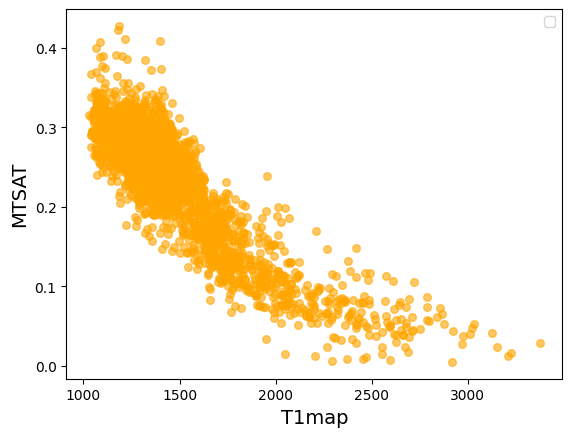

In [396]:
import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(map_means_concat[:, 0], map_means_concat[:, 1], c='orange', marker='o', s=30, alpha=0.6)

#plt.title('Scatter Plot between First and Second Rows of map_means_concat')
plt.xlabel('T1map', fontsize=14)
plt.ylabel('MTSAT', fontsize=14)
plt.legend()
plt.show()

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()

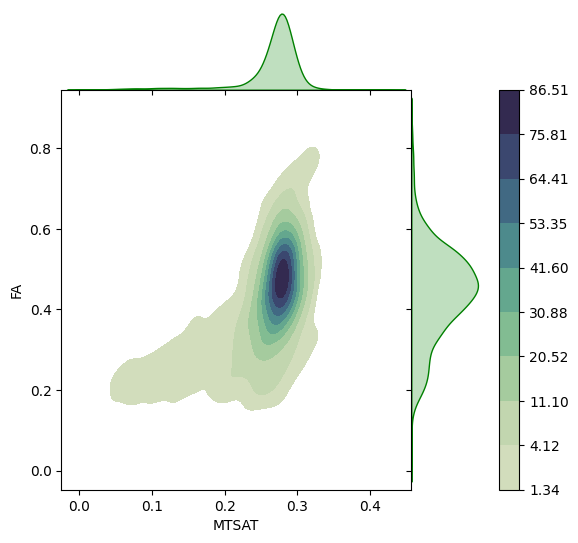

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the concatenated vectors
data = pd.DataFrame(data=map_means_concat, columns=qmri_list)

#cmap = sns.cubehelix_palette(as_cmap=True) # T1map & MTSAT (palevioletred)
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
#cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Plot bivariate distribution (density function)
kdeplot = sns.jointplot(x='MTSAT', y='FA', data=data, color='green', kind='kde', fill=True, space=0, cbar=True, cmap=cmap)

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.labelbottom'] = True

mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.labelright'] = False
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True

plt.show()